# Testing iterative methods

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from modules_no_st import coh_ang_calc
from skimage.transform import rescale
from skimage import color
from numpy.lib.stride_tricks import sliding_window_view

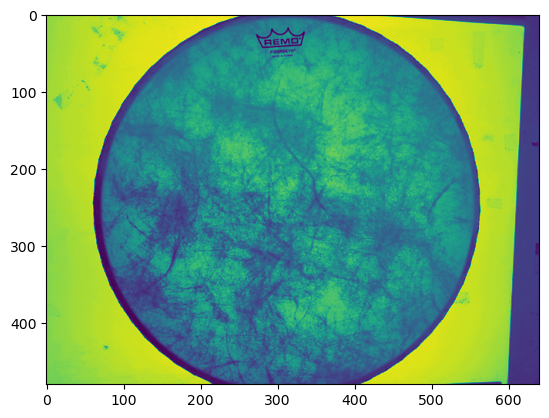

In [2]:
drumhead = cv.imread("drumhead.jpg")
drum_gray = color.rgb2gray(drumhead)
plt.imshow(drum_gray)

In [3]:
# coh, ang = coh_ang_calc(drum_gray)
# plt.imshow(coh)

In [4]:
# plt.imshow(ang)

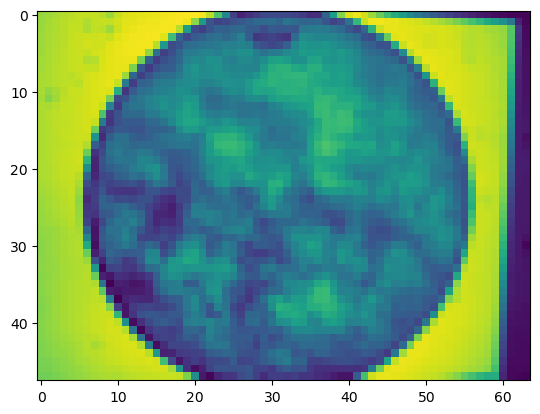

In [5]:
drum_small = rescale(drum_gray, 0.1)
plt.imshow(drum_small)

In [6]:
# iteratively apply diffusion steps - maybe add time_step, analagous to sigma of filter?
def diffuse(img, ksize, diffusion_step, num_steps):
    assert ksize>=1 and ksize%2==1, "kernel must be >= 1 and odd"
    assert num_steps >=0, "must have nonnegative number of steps - no reverse diffusion yet :)"
    if num_steps == 0:
        return img # img without filtering is just img
    
    # shouldn't be bottleneck (i hope)
    for _ in range(num_steps):
        img = diffusion_step(img, ksize)
    return img

def border(img, border_width):
    return cv.copyMakeBorder(img, border_width, border_width, border_width, border_width, cv.BORDER_WRAP)

# kernel diameter of 3, average pixels
# responsible for bordering img before convolution-adjacent operation
def linear_diffusion_step(img, ksize):
    k_radius = ksize//2
    new_img = np.zeros_like(img, dtype=float)
    # print(new_img.shape)
    img_padded = border(img, k_radius)
    h, w = new_img.shape
    for r in range(h):
        for c in range(w):
            # normalization = 1/(ksize * ksize)
            normalization = 1
            avg = np.mean(img_padded[r:r+2*k_radius+1, c:c+2*k_radius+1])
            new_img[r, c] = normalization*avg
    return new_img

# Idea: instead of using 2d for loop, create ndarry of shape(img.shape[0], img.shape[1], ksize, ksize)
# Then, perform almost-convolution with filter[r, c, x, y] *= img[r-ksize//2+x]
# check out numpy vectorize and sliding-window
def linear_diffusion_step_smarter(img, ksize):
    filter = np.ones(img.shape + (ksize, ksize))
    img_padded = border(img, ksize//2)
    window_view = sliding_window_view(img_padded, (ksize, ksize))
    # print(filter.shape, window_view.shape)
    product = filter * window_view
    final_img = np.mean(product, axis=(2, 3))
    return final_img

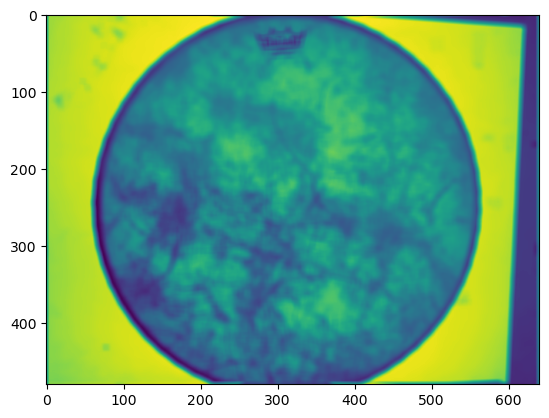

In [7]:
faster_maybe = linear_diffusion_step_smarter(drum_gray, 9)
plt.imshow(faster_maybe)

1.5196869373321533 0.01616668701171875


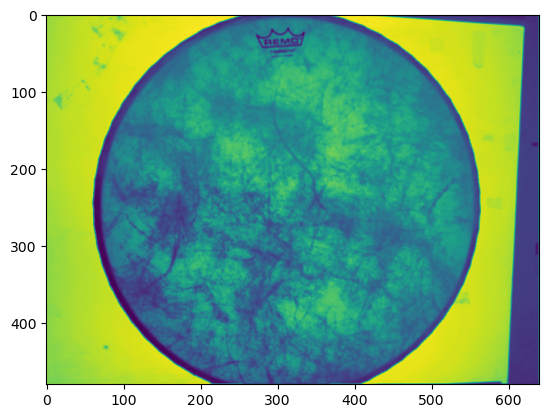

In [10]:
# runtime comparison
import time
t0 = time.time()
blur_drumhead = diffuse(drum_gray, 3, linear_diffusion_step, 1)
t1 = time.time()
blur_drumhead_faster = diffuse(drum_gray, 3, linear_diffusion_step_smarter, 1)
t2 = time.time()
plt.imshow(blur_drumhead)
print(t1 - t0, t2 - t1)

In [11]:
# Note: while both methods yield the same result, using numpy is orders of magnitude faster :)
print((t1-t0)/(t2-t1))
(blur_drumhead == blur_drumhead_faster).all()

94.00113555922606


True

In [12]:
def a_diffusion(img, ksize, sigma=1):
    pass

In [13]:
angle = np.pi * 2
coherence = 0.5
sigma = 1

def RtSR(angle, coherence, sigma):
    sigma_1 = (1 - coherence) * sigma
    R = np.array([[np.cos(angle), -1*np.sin(angle)],
                [np.sin(angle), np.cos(angle)]])
    S = np.array([[sigma_1, 0],
                [0, sigma]])

    SR = np.matmul(S, R)
    return np.matmul(R.T, SR)

In [14]:
def xtAx(x, A):
    return np.matmul(x.T, np.matmul(A, x))

def exponent(x, y, theta, coherence, sigma):
    return xtAx(np.array([x, y], RtSR(theta, coherence, sigma)))

In [54]:
# NOTE: calculation for rotated matrix is WRONG! look up how to actually do it- it's change of basis, not just rotating a vector.
def angled_gaussian(x, y, theta, coherence, sigma=1):
    theta += np.pi/2
    rtsr = RtSR(theta, coherence, sigma)
    xtax = xtAx(np.array([x, y]), rtsr)
    return np.exp(-1*xtax)

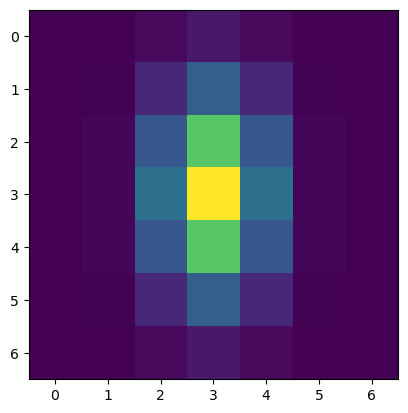

In [55]:
img = np.array([[angled_gaussian(x, y, 0, .7) for x in range(-3, 4)] for y in range(-3, 4)])
img /= img.mean()
plt.imshow(img)

In [45]:
def create_shifted_kernel():
    k_radius = 2
    k_range = np.arange(-k_radius, k_radius + 1, dtype=int)
    np.array(np.meshgrid(k_range, k_range))

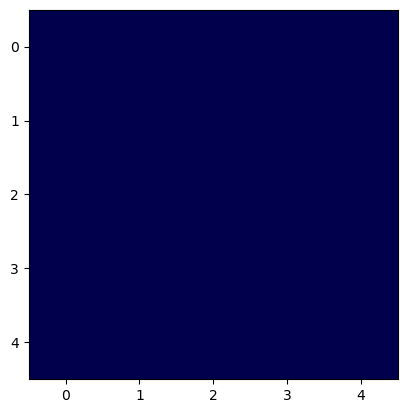

In [98]:
plt.imshow(np.ones((5, 5))*10, cmap='seismic')

In [ ]:
img = None # shape (height, width)
coherence, theta = coh_ang_calc(img, sigma_inner=1, kernel_radius=2) # shape (height, width)
sigma_2 = 1 # shape (1)
sigma_1 = sigma_2 * (1 - coherence) # shape (height, width)
k_radius = 2

s = np.sin(theta) # shape (height, width)
c = np.cos(theta) # shape (height, width)
k_range = np.arange(-k_radius, k_radius + 1, dtype=int)
(x, y) = np.meshgrid(k_range, k_range) # reshape to (1, 1, ksize, ksize)

# A = R^T @ S @ R
# xtax = x^T @ A @ x
# IMPORTANT: x = [x, y], so xtax should have shape (height, width, ksize, ksize)
xtax = (sigma_1 * c * c + sigma_2 * s * s) * x * x + 2 * (sigma_1 - sigma_2) * c * s * x * y + (sigma_1 * s * s + sigma_2 * c * c) * y * y
xtax /= xtax.sum(axis=[2, 3]) # normalizing kernels to sum to 1
expanded = sliding_window_view(border(img, k_radius), (k_radius*2+1, k_radius*2+1)) # shape (height, width, ksize, ksize), NOTE: MAKE SURE TO PAD IMAGE BEFORE EXPANDING


In [103]:
a = np.ones((2, 3))
print(a)
a = a.reshape((1, 2, 3))
print(a)
a = a.reshape((1, 2, 1, 3, 1, 1, 1, 1, 1))
a

[[1. 1. 1.]
 [1. 1. 1.]]
[[[1. 1. 1.]
  [1. 1. 1.]]]


array([[[[[[[[[1.]]]]],




          [[[[[1.]]]]],




          [[[[[1.]]]]]]],






        [[[[[[[1.]]]]],




          [[[[[1.]]]]],




          [[[[[1.]]]]]]]]])